# CNN classifier for TS data from `tuh_eeg_seizure` dataset (windowed)

Disclaimer: everything here was run (and tested) on a UD Darwin HPC node and probably will not fit on Google Colab instance.

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
from matplotlib import pyplot as plt
import pickle

from pathlib import Path
from collections import defaultdict

import seaborn as sn

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rcParams['figure.figsize'] = (20,10)

## Loading data

In [3]:
working_folder = Path('/lustre/acslab/users/2288/Classes/22S-PHYS-667/project/temp_data')

In [4]:
with open(working_folder.joinpath('cat_balanced_resampled_dict.pkl'), 'rb') as f:
    cat_balanced_resampled_dict = pickle.load(f)

In [6]:
cat_balanced_resampled_dict['train']

{'x': array([[[ 2.454665  ,  1.7947098 ,  1.7500725 , ..., -0.8255324 ,
           0.23591004,  3.1521578 ],
         [ 2.0316975 ,  1.5201089 ,  1.5063605 , ..., -0.62997735,
           0.01170261,  2.6928012 ],
         [ 1.8979528 ,  1.4778082 ,  1.3162342 , ..., -0.4878219 ,
          -0.41656822,  2.423162  ],
         ...,
         [ 0.34800842,  0.8765679 ,  1.2340701 , ..., -0.59364784,
          -0.01320481, -0.2094412 ],
         [ 0.46929917,  0.97446185,  1.2073991 , ..., -0.69529325,
           0.35729077, -0.33911574],
         [ 0.77080333,  0.90405446,  1.2379628 , ..., -0.76099914,
          -0.36287028, -0.3996453 ]],
 
        [[-0.04682437,  0.73184484, -0.6882817 , ...,  0.177052  ,
          -0.6176443 , -0.07414263],
         [-0.0634677 ,  0.6453193 , -0.6635744 , ...,  0.27079648,
          -0.6113211 ,  0.01631554],
         [-0.1539604 ,  0.55472594, -0.8110018 , ...,  0.28569508,
          -0.7124685 ,  0.02813992],
         ...,
         [-3.7638626 , -3.34

---
---
---

In [7]:
# custom dataset class

class CustomDataset:
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        current_sample = self.data[idx, :]
        current_target = self.targets[idx]
        
        return {
            'x': torch.tensor(current_sample),
            'y': torch.tensor(current_target, dtype=torch.long),
        }

In [8]:
x_train = cat_balanced_resampled_dict['train']['x'].reshape(
    (
        cat_balanced_resampled_dict['train']['x'].shape[0],
        1, #n_channels
        cat_balanced_resampled_dict['train']['x'].shape[-2],
        cat_balanced_resampled_dict['train']['x'].shape[-1]
    )
)

In [9]:
x_train.shape

(100176, 1, 1999, 21)

In [10]:
y_train = cat_balanced_resampled_dict['train']['y']

In [14]:
x_dev = cat_balanced_resampled_dict['dev']['x'].reshape(
    (
        cat_balanced_resampled_dict['dev']['x'].shape[0],
        1, #n_channels
        cat_balanced_resampled_dict['dev']['x'].shape[-2],
        cat_balanced_resampled_dict['dev']['x'].shape[-1]
    )
)

x_eval = cat_balanced_resampled_dict['eval']['x'].reshape(
    (
        cat_balanced_resampled_dict['eval']['x'].shape[0],
        1, #n_channels
        cat_balanced_resampled_dict['eval']['x'].shape[-2],
        cat_balanced_resampled_dict['eval']['x'].shape[-1]
    )
)

In [15]:
y_dev = cat_balanced_resampled_dict['dev']['y']
y_eval = cat_balanced_resampled_dict['eval']['y']

---
---
---

## ALL dataloaders

In [21]:
n_workers = 16
b_size = 16

In [22]:
dataset = CustomDataset(
    x_train, 
    y_train,
)

In [23]:
train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=b_size,
    shuffle=True,
    num_workers=n_workers,
)

In [24]:
dataset_dev = CustomDataset(
    x_dev, 
    y_dev
)

In [25]:
dev_loader = torch.utils.data.DataLoader(
    dataset_dev,
    batch_size=b_size,
    shuffle=True,
    num_workers=n_workers,
)

In [26]:
dataset_eval = CustomDataset(
    x_eval, 
    y_eval
)

In [27]:
eval_loader = torch.utils.data.DataLoader(
    dataset_eval,
    batch_size=b_size,
    shuffle=True,
    num_workers=n_workers,
)

### How does our data look like?

In [63]:
sample_pos_matrix = cat_balanced_resampled_dict['train']['x'][
    np.where(cat_balanced_resampled_dict['train']['y'] == True)
][np.random.randint(1000)]
sample_neg_matrix = cat_balanced_resampled_dict['train']['x'][
    np.where(cat_balanced_resampled_dict['train']['y'] == False)
][np.random.randint(1000)]

<AxesSubplot:>

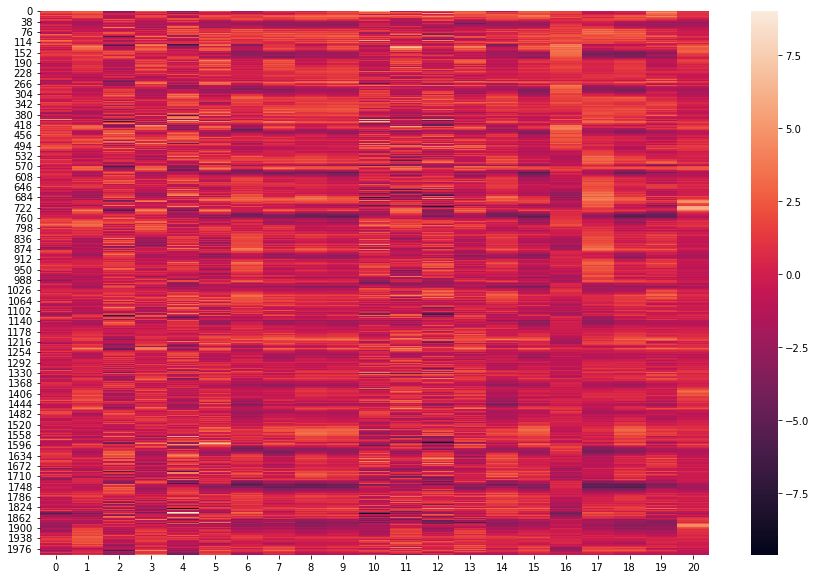

In [64]:
# positive sample 
sn.heatmap(sample_pos_matrix)

<AxesSubplot:>

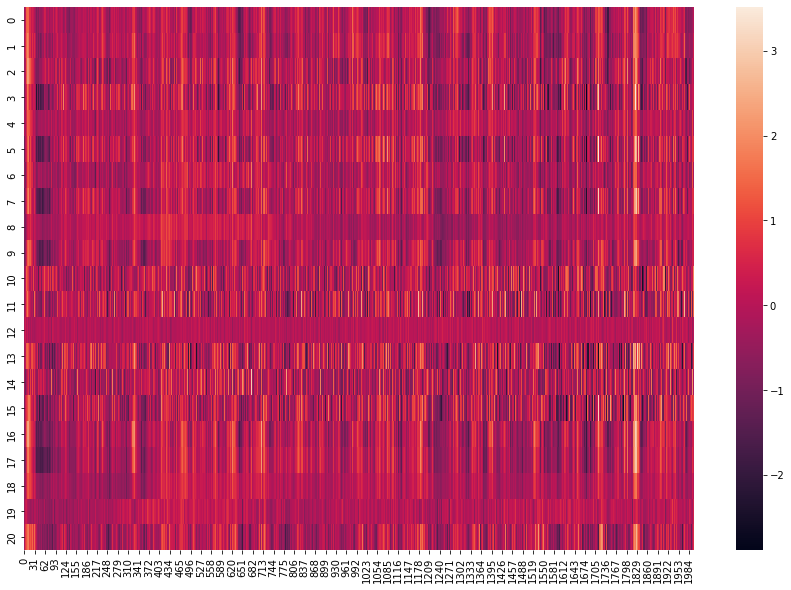

In [66]:
# negative sample

sn.heatmap(sample_neg_matrix.T)

## Model architecture

In [32]:
dropout_prob = 0.3

conv_ch_size = 8
conv_out_ch_size = 4

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [82]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, conv_ch_size, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(conv_ch_size, conv_out_ch_size, 5)
        
        self.batch_norm = nn.BatchNorm2d(conv_out_ch_size)
        
        #self.fc1 = nn.Linear(16 * 5 * 5, 120)
        
        self.fc1 = nn.Linear(1988, 32)
        
        self.dropout = nn.Dropout(dropout_prob)
        
        self.activation = nn.ReLU()
        #self.relu = nn.ReLU()
        
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.batch_norm(x)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        
        x = self.fc1(x)
        x = self.activation(x)
        
        x = self.dropout(x) # apply dropout 
        
        x = self.fc2(x)
        x = self.activation(x)
        
        x = self.fc3(x)
        return x


net = Net()

In [83]:
net.to(device)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 2, kernel_size=(5, 5), stride=(1, 1))
  (batch_norm): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1988, out_features=32, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (activation): ReLU()
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=2, bias=True)
)

## Training loop

In [86]:
tqdm._instances.clear()

In [85]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    net.parameters(), 
    lr=0.001, 
    momentum=0.9, 
    weight_decay=1e-4
)

In [87]:
def test_model(net, data_loader, label):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    net.eval()
    
    with torch.no_grad():
        for data in data_loader:

            images, labels = data['x'].to(device), data['y'].to(device)

            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    #print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    acc = correct/total
    print(f"acc_{label}: {correct/total}")
    net.train()
    
    return acc

In [88]:
print_freq = 1000
n_epochs = 50

In [89]:
train_acc_list = []
dev_acc_list = []

In [90]:
net

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 2, kernel_size=(5, 5), stride=(1, 1))
  (batch_norm): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1988, out_features=32, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (activation): ReLU()
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=2, bias=True)
)

In [91]:
current_epoch = 0

In [92]:
test_every_n = 5

epoch_idx = []
train_acc_list = []
dev_acc_list = []
eval_acc_list = []

In [94]:
epoch_losses = defaultdict(list)

In [95]:
ver = 7

In [ ]:
from collections import defaultdict

net.train()
for epoch in tqdm(list(range(current_epoch, n_epochs))):  # loop over the dataset multiple times
    
    current_epoch = epoch
    
    i = 0
    
    running_loss = 0.0
    for data in train_loader:
        # get the inputs; data is a list of [inputs, labels]
        i += 1
        #inputs, labels = data
        
        #inputs, labels = data[0].to(device),data[1].to(device)
        
        inputs, labels = data['x'].to(device), data['y'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        #if i % print_freq == 0:    # print every print_freq mini-batches
            
            #print(f'[{epoch}, {i + 1:5d}] loss: {running_loss / print_freq:.3f}')
            
            #epoch_losses[epoch].append(running_loss / print_freq)
    
    epoch_losses[epoch] = running_loss
    running_loss = 0.0
        
    
    # saving ckpt
    
    if (epoch % test_every_n) == 0:
        epoch_idx.append(epoch)
        train_acc_list.append(test_model(net, train_loader, label='train'))
        dev_acc_list.append(test_model(net, dev_loader, label='dev'))
        eval_acc_list.append(test_model(net, eval_loader, label='eval'))
        print('', epoch_losses[epoch])
    
    # saving each model to evaluate it later
    torch.save(
        net,
        f'/lustre/acslab/users/2288/Classes/22S-PHYS-667/project/DL/model_epochs_v{ver}/model_v{ver}_ep{str(epoch).zfill(2)}.pt'
    )

print('Finished Training')

## Plotting & Metrics

In [104]:
import matplotlib

In [105]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [86]:
models_paths = sorted(
    list(
        Path(
            f'/lustre/acslab/users/2288/Classes/22S-PHYS-667/project/DL/model_epochs_v{ver}/'
        ).glob('*.pt')
    )
)

In [ ]:
epoch_idx = []
train_acc_list = []
dev_acc_list = []
eval_acc_list = []

for model_fname in tqdm(models_paths[::3] + models_paths[-1:]):
    model = torch.load(model_fname)
    epoch = int(model_fname.stem.split('ep')[-1]) + 1
    print(f'epoch: {epoch}' )
    train_acc_list.append(test_model(model, train_loader, label='train'))
    dev_acc_list.append(test_model(model, dev_loader, label='dev'))
    eval_acc_list.append(test_model(model, eval_loader, label='eval'))
    epoch_idx.append(epoch)

In [101]:
i = 50

Text(0.5, 1.0, 'Accuracy over time')

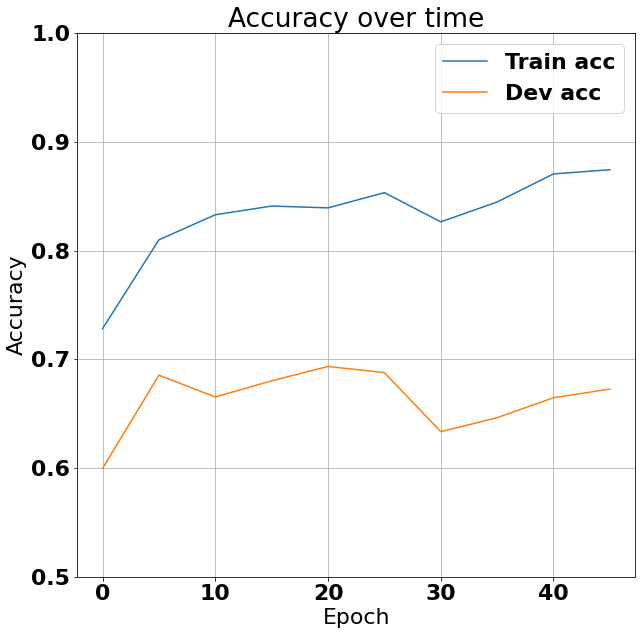

In [261]:
plt.figure(figsize=(10,10))
plt.plot( epoch_idx[:i],train_acc_list[:i], label="Train acc")
plt.plot( epoch_idx[:i], dev_acc_list[:i],label="Dev acc")
#t.plot( epoch_idx[:i], eval_acc_list[:i], label="Eval acc")
#plt.plot([sum(epoch_losses[v]) for v in epoch_losses])
#plt.yscale('log')
plt.legend()
plt.ylim(0.5, 1)
plt.grid('minor')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over time')

### Metrics

In [138]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import scikitplot as skplt
from scipy.special import softmax

In [149]:
def test_model_raw(net, data_loader, label):
    # since we're not training, we don't need to calculate the gradients for our outputs
    net.eval()
    
    outputs_list = []
    real_labels = []
    with torch.no_grad():
        for data in data_loader:

            images, labels = data['x'].to(device), data['y'].to(device)

            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            #total += labels.size(0)
            #correct += (predicted == labels).sum().item()
            outputs_list.append(outputs.detach().cpu().numpy())
            real_labels.append(data['y'].detach().cpu().numpy())

    #print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    #acc = correct/total
    #print(f"acc_{label}: {correct/total}")
    net.train()
    
    return softmax(np.concatenate(outputs_list), axis=1), np.concatenate(real_labels)

In [150]:
raw_outputs = test_model_raw(net, eval_loader, 'eval')

In [151]:
raw_outputs

(array([[0.20522822, 0.79477173],
        [0.43769538, 0.56230456],
        [0.93230903, 0.06769094],
        ...,
        [0.8880417 , 0.11195832],
        [0.14873466, 0.8512654 ],
        [0.2574503 , 0.7425497 ]], dtype=float32),
 array([1, 0, 0, ..., 0, 1, 1]))

#### ROC curve

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

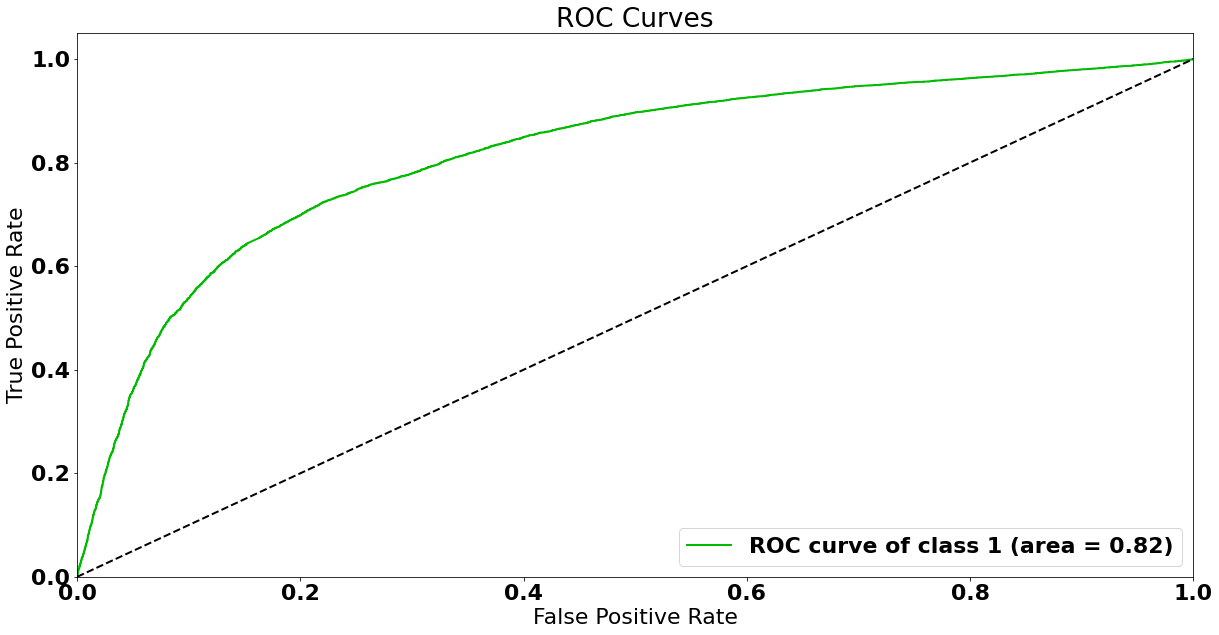

In [196]:
skplt.metrics.plot_roc(raw_outputs[1], raw_outputs[0], plot_micro=False, classes_to_plot=[1], plot_macro=False,)

#### PR curve

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

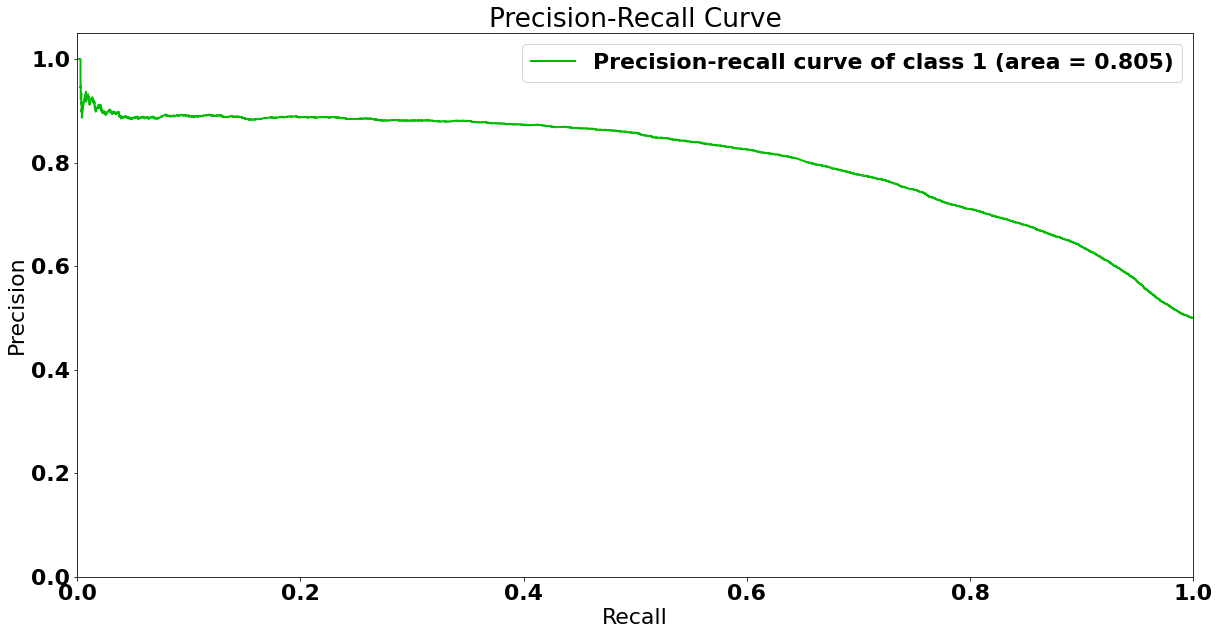

In [230]:
skplt.metrics.plot_precision_recall(raw_outputs[1], raw_outputs[0], classes_to_plot=[1], plot_micro=False)

In [188]:
len(x_train), len(x_dev), len(x_eval)

(100176, 34790, 22552)

#### Confusion matrix

In [182]:
cf_matrix = skplt.metrics.confusion_matrix(raw_outputs[1], np.argmax(raw_outputs[0], axis=1))

Text(0.5, 1.0, 'Confusion matrix for CNN classifier (eval)')

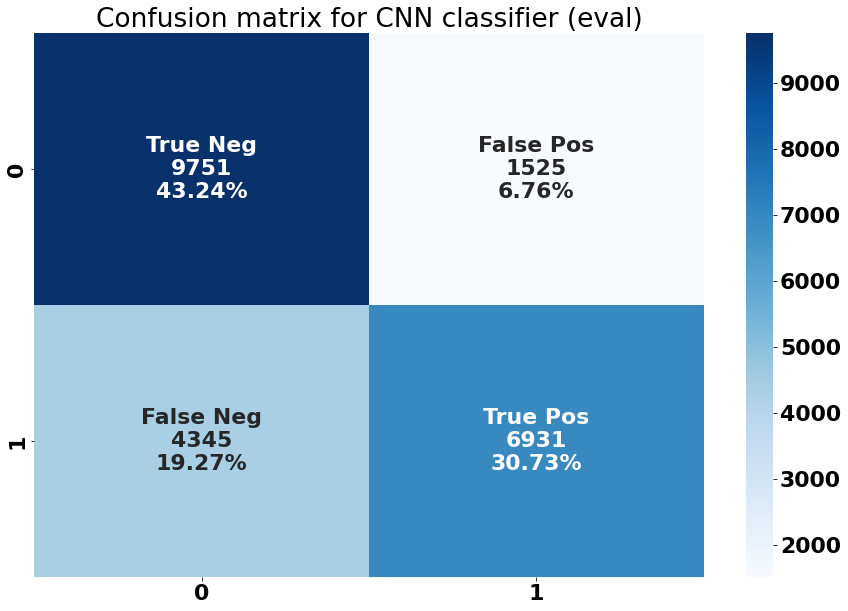

In [225]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(15, 10))
sn.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

plt.title("Confusion matrix for CNN classifier (eval)")